In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
import xgcm
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.5:34273 Dashboard: http://10.148.0.5:8787/status,Cluster Workers: 1 Cores: 28 Memory: 120.00 GB


# 1. Filter

In [10]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
grid_sub = grid.isel(lon=slice(70,110),lat=slice(80,120),lon_g=slice(70,110),lat_g=slice(80,120))

file_out = out_dir_store+'/grid_subdomain.zarr'
%time grid_sub.to_zarr(file_out, mode='w')   

CPU times: user 64 ms, sys: 48 ms, total: 112 ms
Wall time: 2.23 s


In [6]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/data_rechunk/'

u = xr.open_zarr(out_dir_store+'U_subdomain_rechunk.zarr')
v = xr.open_zarr(out_dir_store+'V_subdomain_rechunk.zarr')
w = xr.open_zarr(out_dir_store+'W_subdomain_rechunk.zarr')
b = xr.open_zarr(out_dir_store+'B_subdomain_rechunk.zarr')
grid_sub = xr.open_zarr(out_dir_store+'grid_subdomain.zarr')

ds = xr.merge([u,v,w,b,grid_sub])
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 40, lat_g: 40, lon: 40, lon_g: 40, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    dxC      (lat, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    dyG      (lat, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
  * lat      (lat) float64 48.45 48.47 48.48 48.49 ... 48.92 48.93 48.94 48.96
  * lon_g    (lon_g) float64 -16.58 -16.56 -16.54 ... -15.81 -15.79 -15.77
    rAw      (lat, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dxG      (lat_g, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    dyC      (lat_g, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
  * lat_g    (lat_g) float64 48.45 48.46 48.47 48.48 ... 48.91 48.92 48.94 48.95
  * lon      (lon) float64 -16.57 -16.55 -16.53 -16.51 ... -15.8 -15.78 -15.76
    rAs      (la

In [7]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [8]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, depth_left: 52, lat: 40, lat_g: 40, lon: 40, lon_g: 40, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    dxC      (lat, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    dyG      (lat, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
  * lat      (lat) float64 48.45 48.47 48.48 48.49 ... 48.92 48.93 48.94 48.96
  * lon_g    (lon_g) float64 -16.58 -16.56 -16.54 ... -15.81 -15.79 -15.77
    rAw      (lat, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dxG      (lat_g, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    dyC      (lat_g, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
  * lat_g    (lat_g) float64 48.45 48.46 48.47 48.48 ... 48.91 48.92 48.94 48.95
  * lon      (lon) float64 -16.57 -16.55 -16.53 -16.51 ... -15.8 -15.78 -15.76


In [9]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 40, lon_g: 40)>
dask.array<mul, shape=(40, 40), dtype=float32, chunksize=(40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lon_g    (lon_g) float64 -16.58 -16.56 -16.54 ... -15.81 -15.79 -15.77
  * lat_g    (lat_g) float64 48.45 48.46 48.47 48.48 ... 48.91 48.92 48.94 48.95
    XG       (lat_g, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    YG       (lat_g, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    rAz      (lat_g, lon_g) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>

In [10]:
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## low-pass

In [11]:
lowcut = 1/24/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq

c, d = butter(4, low, 'low')

In [12]:
U_filter = butter_filter(ds.U, c, d)
V_filter = butter_filter(ds.V, c, d)
W_filter = butter_filter(ds.W, c, d)
B_filter = butter_filter(ds.B, c, d)

____________
# 3. Calculate


In [16]:
db_dx = gridx.diff(B_filter,'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dy = gridx.diff(B_filter,'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

zeta = (gridx.diff(ds.dyC*V_filter,'X') - gridx.diff(ds.dxC * U_filter,'Y'))/ds.rAz   # zeta
zeta_i =  gridx.interp(zeta,'X')
zeta_ij =  gridx.interp(zeta_i,'Y')

db_dz_left = -1*gridx.diff(B_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)


PV = (f_ij + zeta_ij)*db_dz - (db_dx_ij**2 + db_dy_ij**2)/f_ij
#chunks = {'time': 9415, 'lat': 40, 'lon': 40, 'depth':1}
#PV = PV.chunk(chunks)
PV

<xarray.DataArray (lat: 40, lon: 40, time: 9415, depth: 52)>
dask.array<sub, shape=(40, 40, 9415, 52), dtype=float32, chunksize=(38, 38, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 48.45 48.47 48.48 48.49 ... 48.92 48.93 48.94 48.96
  * lon      (lon) float64 -16.57 -16.55 -16.53 -16.51 ... -15.8 -15.78 -15.76
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

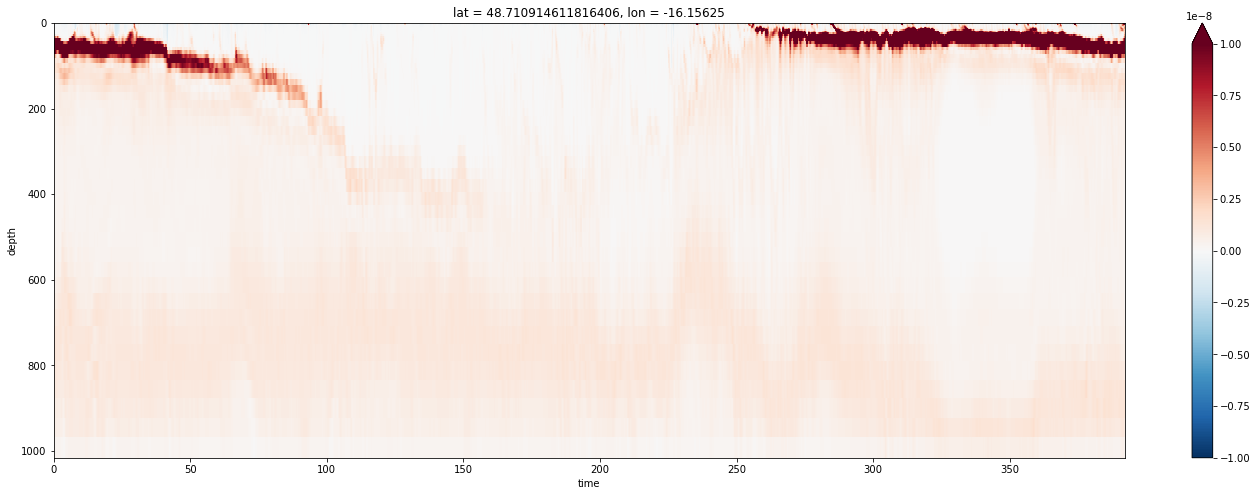

In [17]:
fig = plt.figure(figsize=(24,8))

PV.isel(lat=20,lon=20).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)

## Budget

In [37]:
dq_dt = ( PV.shift(time=-1) - PV.shift(time=1) )/2/3600
dq_dt

<xarray.DataArray (lat: 40, lon: 40, time: 9415, depth: 52)>
dask.array<truediv, shape=(40, 40, 9415, 52), dtype=float32, chunksize=(38, 38, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 48.45 48.47 48.48 48.49 ... 48.92 48.93 48.94 48.96
  * lon      (lon) float64 -16.57 -16.55 -16.53 -16.51 ... -15.8 -15.78 -15.76
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [36]:
h_advection = (gridx.interp(U_filter*ds.dxC*gridx.diff(PV,'X'),'X') + gridx.interp(V_filter*ds.dyC*gridx.diff(PV,'Y'),'Y'))/ds.rA
h_advection

<xarray.DataArray (time: 9415, depth: 52, lat: 40, lon: 40)>
dask.array<truediv, shape=(9415, 52, 40, 40), dtype=float32, chunksize=(9415, 1, 36, 36), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 48.45 48.47 48.48 48.49 ... 48.92 48.93 48.94 48.96
  * lon      (lon) float64 -16.57 -16.55 -16.53 -16.51 ... -15.8 -15.78 -15.76
    CS       (lat, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    Depth    (lat, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    SN       (lat, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    XC       (lat, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    YC       (lat, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    rA       (lat, lon) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>

In [41]:
dq_dz_left = -1*gridx.diff(PV, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
dq_dz = gridx.interp(dq_dz_left,'Z', boundary='fill')
dq_dz = dq_dz.astype(np.float32)
dq_dz
w_advection = W_filter*dq_dz

<xarray.DataArray 'mul-0bb0fd436000d141504975fecfcbfdf7' (lat: 40, lon: 40, time: 9415, depth: 52)>
dask.array<astype, shape=(40, 40, 9415, 52), dtype=float32, chunksize=(38, 38, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 48.45 48.47 48.48 48.49 ... 48.92 48.93 48.94 48.96
  * lon      (lon) float64 -16.57 -16.55 -16.53 -16.51 ... -15.8 -15.78 -15.76
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

## Figure

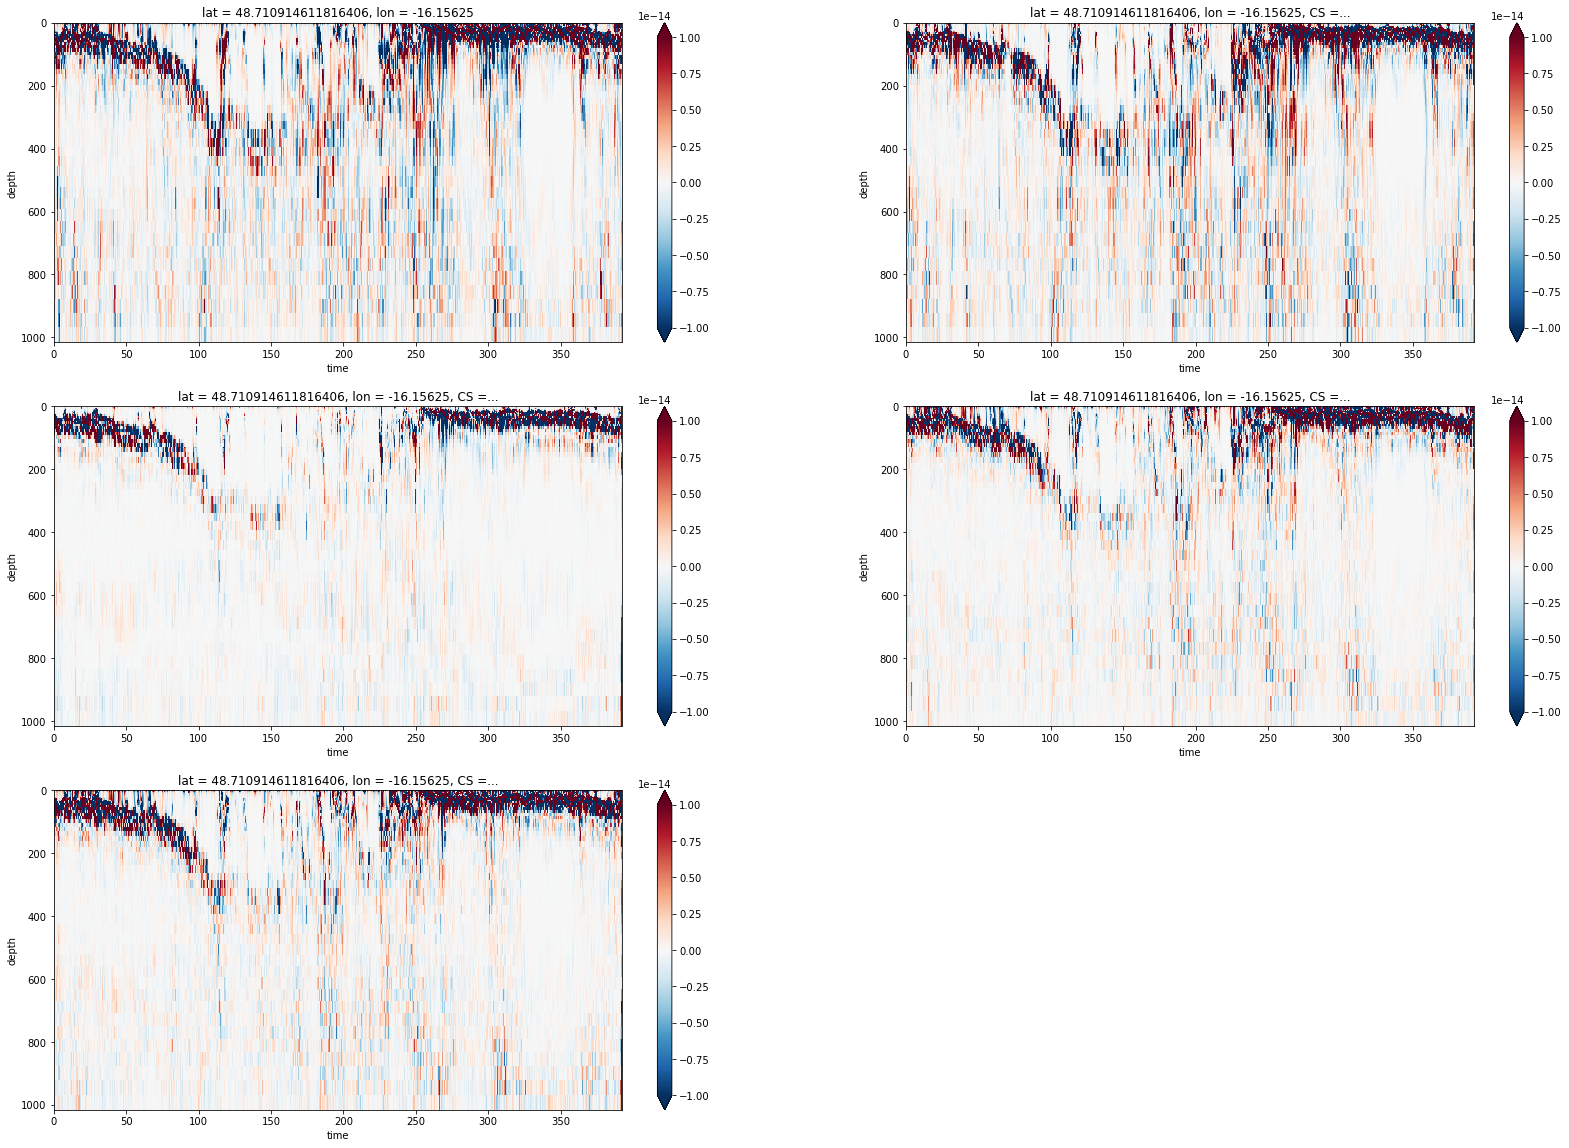

In [49]:
fig = plt.figure(figsize=(28,20))

plt.subplot(321)
dq_dt.isel(lat=20,lon=20).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-14, vmax=1e-14, yincrease=False)

plt.subplot(322)
h_advection.isel(lat=20,lon=20).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-14, vmax=1e-14, yincrease=False)

plt.subplot(323)
w_advection.isel(lat=20,lon=20).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-14, vmax=1e-14, yincrease=False)

plt.subplot(324)
(dq_dt+h_advection).isel(lat=20,lon=20).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-14, vmax=1e-14, yincrease=False)

plt.subplot(325)
(dq_dt+h_advection+w_advection).isel(lat=20,lon=20).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-14, vmax=1e-14, yincrease=False)

(0, 80)

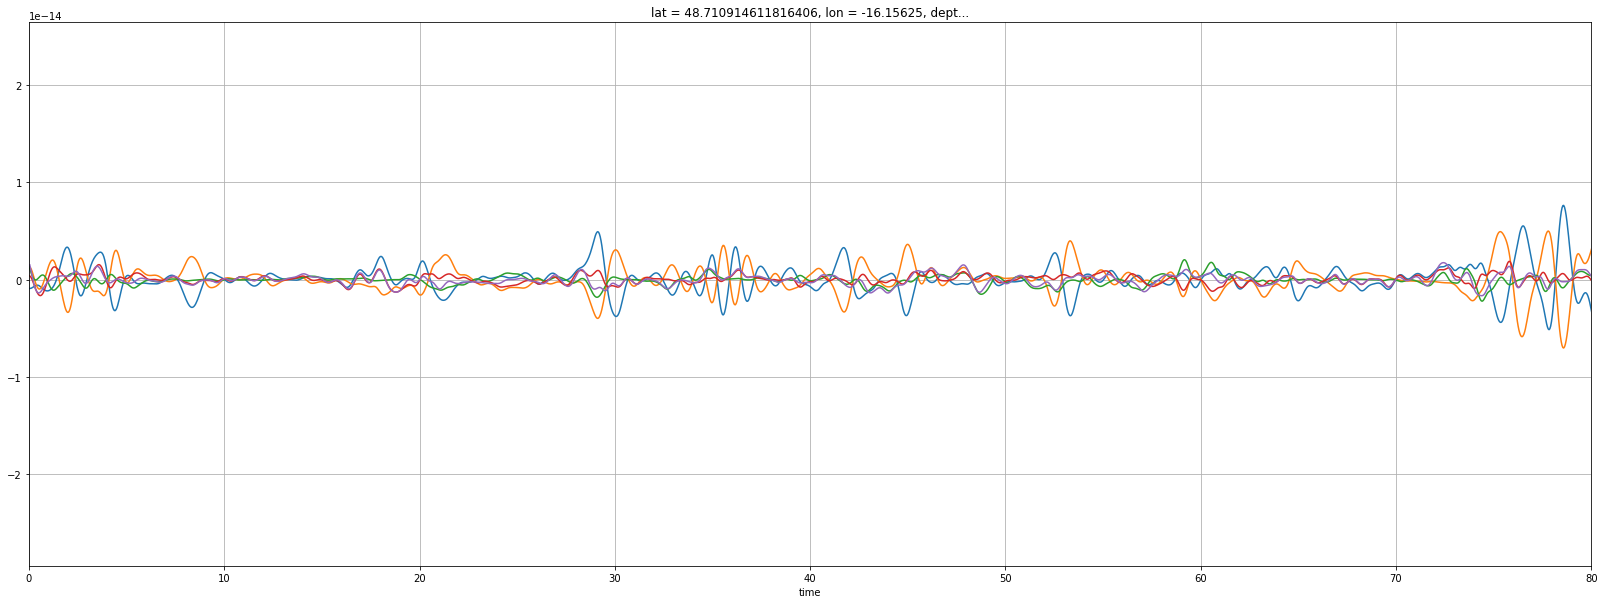

In [50]:
fig, ax = plt.subplots(figsize=(28,10))
ax = plt.subplot(111)
dq_dt.isel(lat=20,lon=20,depth=30).plot(x='time')
h_advection.isel(lat=20,lon=20,depth=30).plot(x='time')
w_advection.isel(lat=20,lon=20,depth=30).plot(x='time')
(dq_dt+h_advection).isel(lat=20,lon=20,depth=30).plot(x='time')
(dq_dt+h_advection+w_advection).isel(lat=20,lon=20,depth=30).plot(x='time')

ax.grid()

ax.set_xlim([0,80])

In [52]:
cluster.close()